In [1]:
from IPython.display import display, HTML
display(HTML ("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}""
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# 데이터셋을 라이브러리에서 가져올 예정. 파일에서도 봄

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU, ReLU
from matplotlib import pyplot as plt # 학습과정 시각화
# scale 조정, train_test_split 등을 추가

In [3]:
data = np.loadtxt('data/mnist_train_small.csv', delimiter=',', skiprows=1)
data.shape

(100, 785)

In [4]:
print('타겟 :', data[1,0])
#print('이미지(784pixel=28*28)', data[1, 1:].rehsape(28,28))
image = data[1,1:].reshape(28,28)
image.shape

타겟 : 0.0


(28, 28)

In [5]:
for row in image:
    for pixel in row:
        print("{:3.0f}".format(pixel), end='')
    print()

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 51159253159 50  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 48238252252252237  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 54227253252239233252 57  6  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 10 60224252253252202 84252253122  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0163252252252253252252 96189253167  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 51238253253190114253228 47 79255168  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 48238252252179 12 75121 21  0  0253243 50  0  0  0  0  0
  0  0  0  0  0  0  0  0 38165253233208 84  0  0  0  0  0  025325

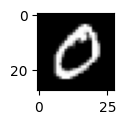

In [6]:
plt.figure(figsize=(1,1))
plt.imshow(image, cmap='gray')

In [7]:
# 칼라사진 -> 흑백모드로 넘파이 배열로 읽기

In [8]:
%pip install opencv-python==4.8.1.78

Note: you may need to restart the kernel to use updated packages.


In [9]:
import cv2
image_gray = cv2.imread('data/sample.jpg', cv2.IMREAD_GRAYSCALE)
image_gray.shape

(408, 612)

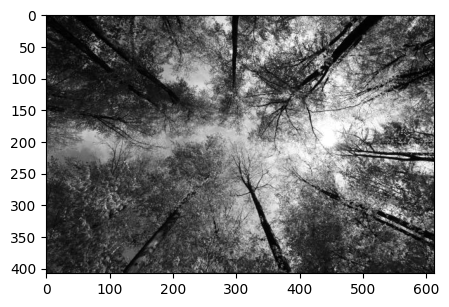

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(image_gray, cmap='gray')

# 1. 데이터 생성 및 전처리

In [11]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

2


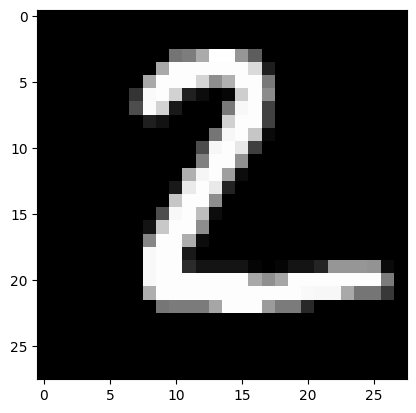

In [12]:
print(y_test[1])
plt.imshow(X_test[1], cmap='gray')
plt.show()
# for row in X_test[0]:
#     for pixel in row:
#         print("{:3.0f}".format(pixel), end='')
#     print()

In [13]:
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]

In [14]:
print('학습 셋:', X_train.shape, y_train.shape)
print('검증 셋:', X_val.shape, y_val.shape)
print('시험셋:', X_test.shape, y_test.shape)

학습 셋: (50000, 28, 28) (50000,)
검증 셋: (10000, 28, 28) (10000,)
시험셋: (10000, 28, 28) (10000,)


In [15]:
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
train_X.shape

(50000, 784)

In [16]:
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0
train_X.shape, val_X.shape, test_X.shape

((50000, 784), (10000, 784), (10000, 784))

In [17]:
# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])
# to_categorical(y_train)[0]
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)
train_Y.shape, val_Y.shape, test_Y.shape

((50000, 10), (10000, 10), (10000, 10))

In [18]:
# Train 5만 -> 700개, Val 만 -> 300개 (목적:수업시간 중 fit시간 절약)
train_idx = np.random.choice(50000, 700) # 0~10미만의 수 700개 뽑기
val_idx = np.random.choice(10000, 300)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X = val_X[val_idx]
val_Y = val_Y[val_idx]

In [22]:
train_X.shape, train_Y.shape, val_X.shape, val_Y.shape

((700, 784), (700, 10), (300, 784), (300, 10))

# 2. 모델구성

In [23]:
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2)) # activation='Leakeyrelu' 사용불가
# model.add(ReLU())
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dense(units=10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 1570      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


# 3. 학습과정 설정

In [24]:
model.compile(loss='categorical_crossentropy', # sparse_categoricla_crossentropy
             optimizer='adam',
             metrics=['accuracy']) # 평가지표

# 4. 모델 학습

In [26]:
%%time
hist = model.fit(train_X, train_Y, # 학습셋
                 epochs=200,
                 batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0)

CPU times: total: 6.19 s
Wall time: 5.47 s


# 5. 모델 평가하기

In [27]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

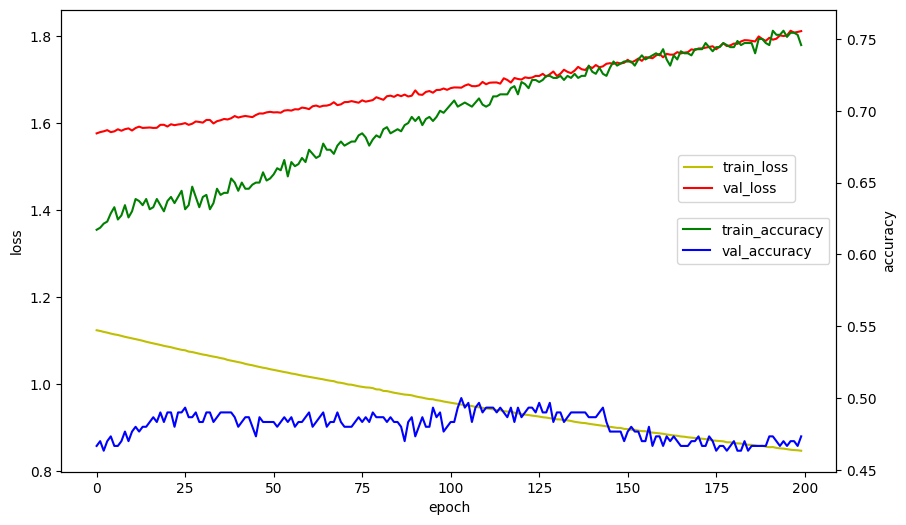

In [29]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [30]:
# 모델 평가(테스트셋)
loss_metrics = model.evaluate(test_X, test_Y, batch_size=100, verbose=0)
print('loss:', loss_metrics[0])
print('accuracy:', loss_metrics[0])

loss: 1.7304069995880127
accuracy: 1.7304069995880127


# 위 모델(DNN)의 accuracy 늘리기
- 데이터 확보
- 모델 수정 (레이어 추가, units수 증가)
- 과적합 방지(validation data 추가, 활성화 함수 relu계열, tanh, dropout)
- epoch 조정
- optimizer 변경

In [42]:
%%time
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X = X_val.reshape(-1, 784).astype('float32')/255.0
test_X = X_test.reshape(10000, -1).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])
# to_categorical(y_train)[0]
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y = to_categorical(y_val)
test_Y = to_categorical(y_test)

model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=1024, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(units=256, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(units=128, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu')) 
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu')) 
model.add(Dropout(0.3))
model.add(LeakyReLU(alpha=0.01)) # 음수결과에 대해 1%만 통과
model.add(Dense(units=10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', # sparse_categoricla_crossentropy
             optimizer='adam',
             metrics=['accuracy']) # 평가지표

hist = model.fit(train_X, train_Y, # 학습셋
                 epochs=20,
                 batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 1024)              803840    
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               524800    
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dropout_17 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 128)              

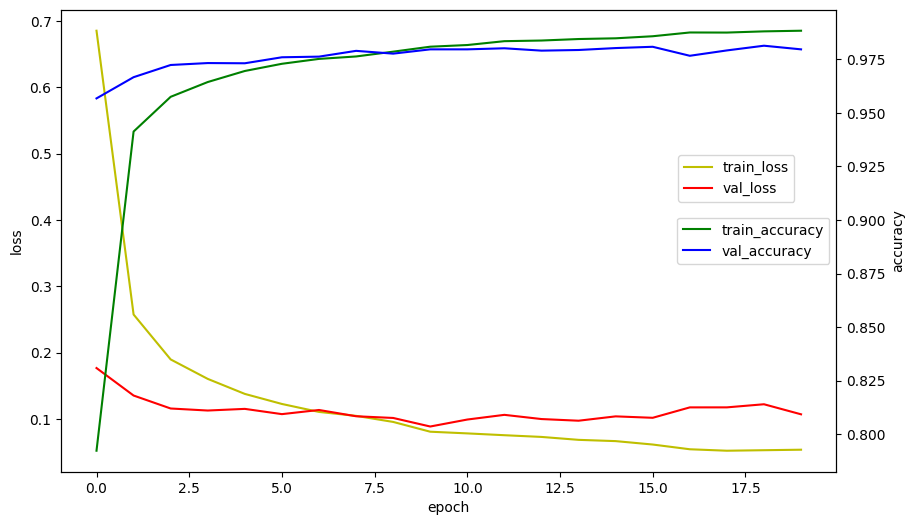

In [43]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [44]:
# 모델 평가
score = model.evaluate(test_X, test_Y)
score[1]

313/313 [==============================] - 1s 4ms/step - loss: 0.1021 - accuracy: 0.9815


0.9815000295639038

In [45]:
# 교차표
np.all(test_Y.argmax(axis=1) == y_test) # 실제값(y_test)

True

In [46]:
# model.predict(test_X).argmax(axis=1)
y_hat = np.argmax(model.predict(test_X), axis=1) # 예측값

313/313 [==============================] - 1s 3ms/step


In [47]:
pd.crosstab(y_test, y_hat, rownames=['실제값'], colnames=['예측값'])

예측값,0,1,2,3,4,5,6,7,8,9
실제값,,,,,,,,,,
0,970,1,1,1,1,0,1,1,2,2
1,0,1127,2,0,0,0,4,0,2,0
2,3,0,1015,4,2,0,1,3,4,0
3,1,0,0,999,0,3,0,3,2,2
4,0,0,1,1,961,0,4,1,0,14
5,4,0,0,13,1,866,3,0,2,3
6,2,2,1,0,4,4,943,0,2,0
7,0,2,9,3,1,0,0,1009,1,3
8,3,0,8,15,5,3,1,2,934,3


In [48]:
# 틀린 갯수
10000-10000*score[1]

184.9997043609619

## ※ 콜백함수1 : 로그출력

In [49]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [51]:
%%time
# 특정 에포크마다 로그출력하도록 제한
class CustomHistory(Callback):
    def __init__(self): # 생성자함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        '1 epoch마다 자동 실행되는 함수'
        self.epoch += 1
        if self.epoch%10 == 0:
            print('epoch:{}, loss:{:.4f}, acc:{:.4f}, val_loss:{:.4f}, val_acc:{:.4f}'\
                  .format(self.epoch, 
                          logs.get('loss'), 
                          logs.get('accuracy', '-'),
                          logs.get('val_loss', '-'), 
                          logs.get('val_accuracy', '-')
                )
            )

(X_train, y_train), (X_test, y_test) = mnist.load_data()
# Train데이터 6만개 => Train(5만개) + val(만개)로 분리
X_val = X_train[50000:]
y_val = y_train[50000:]
X_train = X_train[:50000]
y_train = y_train[:50000]
# 입력(독립) 변수 (n, 28, 28) -> (n, 28*28) -> 실수형변환 -> 스케일조정(/255.0)
train_X = X_train.reshape(50000, 28*28).astype('float32')/255.0
val_X   = X_val.reshape(-1, 784).astype('float32')/255.0
test_X  = X_test.reshape(10000, -1).astype('float32')/255.0
# 분류분석을 위한 타겟변수의 원핫인코딩
# print(y_train[0])
# to_categorical(y_train)[0]
train_Y = to_categorical(y_train, 10) # 10:카테고리수(안쓰면 자동 입력)
val_Y   = to_categorical(y_val)
test_Y  = to_categorical(y_test)
# Train 5만->700개, Val만->300개 (목적:수업시간 중 fit시간 절약)
train_idx = np.random.choice(50000, 700) # 0~50000미만의 수 700개 비복원추출
val_idx   = np.random.choice(10000, 300)
train_X = train_X[train_idx]
train_Y = train_Y[train_idx]
val_X   = val_X[val_idx]
val_Y   = val_Y[val_idx]
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표
customHistory = CustomHistory()  
hist = model.fit(train_X, train_Y, # 학습셋
                epochs=50,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=0,
                callbacks=[customHistory]) # 콜백함수

epoch:10, loss:2.0831, acc:0.2643, val_loss:2.0989, val_acc:0.2233
epoch:20, loss:1.9193, acc:0.2914, val_loss:1.9533, val_acc:0.2500
epoch:30, loss:1.8067, acc:0.3000, val_loss:1.8555, val_acc:0.2667
epoch:40, loss:1.7312, acc:0.3043, val_loss:1.7931, val_acc:0.2733
epoch:50, loss:1.6747, acc:0.3086, val_loss:1.7479, val_acc:0.2800
CPU times: total: 2.41 s
Wall time: 2.05 s


## ※ 콜백함수2 : EarlyStopping
- val_loss값이 늘어나면 지정한 epoch를 다 수행하지 않고 조기 종료
- val_accuracy값이 감소하면 지정한 epoch를 다 수행하지 않고 조기 종료

In [52]:
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표

# monitor 기준으로 patience번 이상 안 좋은 데이터가 나오면 조기 종료
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=3)

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=500,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[earlyStopping]) # 콜백함수

Epoch 1/500
7/7 [==============================] - 0s 19ms/step - loss: 2.2811 - accuracy: 0.1471 - val_loss: 2.2656 - val_accuracy: 0.1567
Epoch 2/500
7/7 [==============================] - 0s 5ms/step - loss: 2.2487 - accuracy: 0.1614 - val_loss: 2.2383 - val_accuracy: 0.1600
Epoch 3/500
7/7 [==============================] - 0s 5ms/step - loss: 2.2206 - accuracy: 0.1757 - val_loss: 2.2101 - val_accuracy: 0.2000
Epoch 4/500
7/7 [==============================] - 0s 5ms/step - loss: 2.1877 - accuracy: 0.1986 - val_loss: 2.1608 - val_accuracy: 0.1933
Epoch 5/500
7/7 [==============================] - 0s 5ms/step - loss: 2.1400 - accuracy: 0.1600 - val_loss: 2.1149 - val_accuracy: 0.1567
Epoch 6/500
7/7 [==============================] - 0s 5ms/step - loss: 2.0930 - accuracy: 0.1643 - val_loss: 2.0698 - val_accuracy: 0.1867


## ※ 콜백함수 3 : ModelCheckpoint
- epoch마다 val_accuracy(val_loss, accuracy, loss)값이 좋을 때 모델을 자동 저장하는 콜백

In [53]:
# 모델
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(units=2, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.compile(loss='categorical_crossentropy', # sparse_categorical_crossentropy
             optimizer='adam',
             metrics=['accuracy'])# 평가지표
# 모델 자동 자정 콜백
import os
model_save_folder = '../model08'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더 생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'mnist-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(
               filepath= file,
               monitor='val_accuracy', # 모니터할 지표(기본값 val_loss)
               save_best_only=True, # 모니터링 지표가 개선된 경우만 저장
               mode = 'max', # 값이 클수록 저장
               verbose=1
)

hist = model.fit(train_X, train_Y, # 학습셋
                epochs=100,
                batch_size=100,
                validation_data=(val_X, val_Y),
                verbose=1,
                callbacks=[checkpoint]) # 콜백함수

Epoch 1/100
1/7 [===>..........................] - ETA: 1s - loss: 2.2964 - accuracy: 0.1100
Epoch 1: val_accuracy improved from -inf to 0.05333, saving model to ..\model08mnist-001-val0.0533.h5
7/7 [==============================] - 0s 21ms/step - loss: 2.2942 - accuracy: 0.0814 - val_loss: 2.2830 - val_accuracy: 0.0533
Epoch 2/100
1/7 [===>..........................] - ETA: 0s - loss: 2.2690 - accuracy: 0.0800
Epoch 2: val_accuracy improved from 0.05333 to 0.08000, saving model to ..\model08mnist-002-val0.0800.h5
7/7 [==============================] - 0s 7ms/step - loss: 2.2647 - accuracy: 0.0814 - val_loss: 2.2663 - val_accuracy: 0.0800
Epoch 3/100
1/7 [===>..........................] - ETA: 0s - loss: 2.2154 - accuracy: 0.1300
Epoch 3: val_accuracy improved from 0.08000 to 0.10000, saving model to ..\model08mnist-003-val0.1000.h5
7/7 [==============================] - 0s 7ms/step - loss: 2.2384 - accuracy: 0.0929 - val_loss: 2.2451 - val_accuracy: 0.1000
Epoch 4/100
1/7 [===>......

1/7 [===>..........................] - ETA: 0s - loss: 1.8772 - accuracy: 0.3600
Epoch 27: val_accuracy improved from 0.29000 to 0.29667, saving model to ..\model08mnist-027-val0.2967.h5
7/7 [==============================] - 0s 8ms/step - loss: 1.8719 - accuracy: 0.3043 - val_loss: 1.9928 - val_accuracy: 0.2967
Epoch 28/100
1/7 [===>..........................] - ETA: 0s - loss: 1.8320 - accuracy: 0.3600
Epoch 28: val_accuracy improved from 0.29667 to 0.30333, saving model to ..\model08mnist-028-val0.3033.h5
7/7 [==============================] - 0s 7ms/step - loss: 1.8627 - accuracy: 0.3186 - val_loss: 1.9901 - val_accuracy: 0.3033
Epoch 29/100
1/7 [===>..........................] - ETA: 0s - loss: 1.7958 - accuracy: 0.3700
Epoch 29: val_accuracy did not improve from 0.30333
7/7 [==============================] - 0s 5ms/step - loss: 1.8530 - accuracy: 0.3143 - val_loss: 1.9852 - val_accuracy: 0.3000
Epoch 30/100
1/7 [===>..........................] - ETA: 0s - loss: 1.9127 - accuracy:

Epoch 55/100
1/7 [===>..........................] - ETA: 0s - loss: 1.6639 - accuracy: 0.4300
Epoch 55: val_accuracy did not improve from 0.35000
7/7 [==============================] - 0s 5ms/step - loss: 1.6674 - accuracy: 0.4200 - val_loss: 1.8616 - val_accuracy: 0.3433
Epoch 56/100
1/7 [===>..........................] - ETA: 0s - loss: 1.8480 - accuracy: 0.4000
Epoch 56: val_accuracy did not improve from 0.35000
7/7 [==============================] - 0s 5ms/step - loss: 1.6620 - accuracy: 0.4300 - val_loss: 1.8552 - val_accuracy: 0.3467
Epoch 57/100
1/7 [===>..........................] - ETA: 0s - loss: 1.7217 - accuracy: 0.3800
Epoch 57: val_accuracy did not improve from 0.35000
7/7 [==============================] - 0s 5ms/step - loss: 1.6554 - accuracy: 0.4257 - val_loss: 1.8552 - val_accuracy: 0.3467
Epoch 58/100
1/7 [===>..........................] - ETA: 0s - loss: 1.7690 - accuracy: 0.3400
Epoch 58: val_accuracy did not improve from 0.35000
7/7 [==============================

7/7 [==============================] - 0s 5ms/step - loss: 1.5206 - accuracy: 0.4829 - val_loss: 1.7628 - val_accuracy: 0.3533
Epoch 85/100
1/7 [===>..........................] - ETA: 0s - loss: 1.5120 - accuracy: 0.4700
Epoch 85: val_accuracy did not improve from 0.36333
7/7 [==============================] - 0s 5ms/step - loss: 1.5159 - accuracy: 0.4843 - val_loss: 1.7565 - val_accuracy: 0.3600
Epoch 86/100
1/7 [===>..........................] - ETA: 0s - loss: 1.4447 - accuracy: 0.5200
Epoch 86: val_accuracy improved from 0.36333 to 0.36667, saving model to ..\model08mnist-086-val0.3667.h5
7/7 [==============================] - 0s 7ms/step - loss: 1.5117 - accuracy: 0.4843 - val_loss: 1.7543 - val_accuracy: 0.3667
Epoch 87/100
1/7 [===>..........................] - ETA: 0s - loss: 1.4102 - accuracy: 0.5200
Epoch 87: val_accuracy improved from 0.36667 to 0.37000, saving model to ..\model08mnist-087-val0.3700.h5
7/7 [==============================] - 0s 6ms/step - loss: 1.5075 - accur